WIP: This notebook tries a simple mlp.

In [ ]:
import re

In [2]:
import struct 

## Load weights

In [386]:
binary_file = open("data/smaller.mat", "rb")
# Read the whole file at once
data = binary_file.read()
data_lines = data.decode('ascii')[3:].split('\n')

In [387]:
def read_kaldi_lines(data_lines):
    """
    Niether pykaldi nor kaldi_io work...
    """
    
    numeric_const_pattern = r"""
     [-+]? # optional sign
     (?:
         (?: \d* \. \d+ ) # .1 .12 .123 etc 9.1 etc 98.1 etc
         |
         (?: \d+ \.? ) # 1. 12. 123. etc 1 12 123 etc
     )
     # followed by optional exponent part if desired
     (?: [Ee] [+-]? \d+ ) ?
     """
    rx = re.compile(numeric_const_pattern, re.VERBOSE)


    list_weights = []
    mat = None
    for line in data_lines:
        if '[' in line:
            if mat is not None:
                list_weights.append(mat)
            mat = []
        # if there are numbers in there
        numbers = rx.findall(line)
        if len(numbers):
            numbers = [float(n) for n in numbers]
            mat.append(numbers)
        if ']' in line:
            if mat is not None:
                list_weights.append(mat)
            mat = None
    return list_weights
        

In [388]:
list_weights = read_kaldi_lines(data_lines)
for w in list_weights:
    print('{}x{}'.format(len(w), len(w[0])))
    print(np.array(w).mean())

32x67
-0.0009576123430177228
1x32
-0.06161756875000001
32x32
-0.0357959157600586
1x32
-0.3890629003125
2x32
5.929999999997526e-06
1x2
-1.5000000003206893e-07


## Create network for the loaded weights

In [389]:
import tensorflow as tf

In [607]:
input_spec = tf.placeholder(tf.float32, shape=(1,500,67))

In [608]:
h1 = tf.layers.dense(input_spec, 32, tf.math.sigmoid,
                     kernel_initializer=tf.constant_initializer(list_weights[0], dtype=tf.float32),
                     bias_initializer=tf.constant_initializer(list_weights[1], dtype=tf.float32))
h2 = tf.layers.dense(h1, 32, tf.math.sigmoid,
                     kernel_initializer=tf.constant_initializer(list_weights[2], dtype=tf.float32),
                     bias_initializer=tf.constant_initializer(list_weights[3], dtype=tf.float32))
h3 = tf.layers.dense(h2, 2, tf.math.softmax,
                     kernel_initializer=tf.constant_initializer(list_weights[4], dtype=tf.float32),
                     bias_initializer=tf.constant_initializer(list_weights[5], dtype=tf.float32))

In [609]:
sess = tf.Session()

In [610]:
sess.run(tf.global_variables_initializer())

## Load data for network

In [12]:
from collections import namedtuple
import itertools
import glob
import logging
import os
import random


import argparse
import numpy as np
import pydub

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import IPython.display as ipd
import librosa.display

In [592]:
import soundfile as sf

y, samplerate = sf.read('data/whispers.wav')

In [657]:
y.max()

0.4860272705554962

## Format data to go into network

In [698]:
f = open('data/cmvn_smaller.mat')
data_lines = f.readlines()

In [699]:
cmvn = read_kaldi_lines(data_lines)

In [700]:
mun, vn = np.array(cmvn[0][0]), np.array(cmvn[0][1])

In [701]:
mun_np = np.expand_dims(mun[1:]/ 2.0**31, 0)
mun_np = np.expand_dims(mun_np, 0)
vn_np = np.expand_dims(vn[1:]/ 2.0**31, 0)
vn_np = np.expand_dims(vn_np, 0)

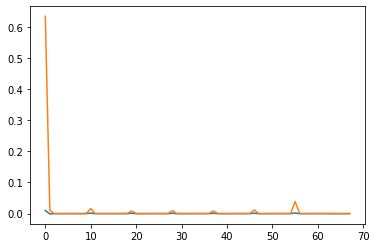

In [702]:
plt.plot(mun[:]/ 2.0**32)
plt.plot(vn[:] / 2.0**32)

In [17]:
from librosa.filters import mel

In [193]:
from python_speech_features import logfbank

In [703]:
sr = 16000
nfft = 256*2

In [775]:
lfbe = logfbank(np.array(y, dtype=np.float32), samplerate=sr, nfilt=64,winlen=0.025,winstep=0.01,nfft=nfft).T
lfbe = lfbe[::-1,:]
lfbe.shape
# feedme = np.expand_dims(features,0)
# feedme = np.pad(feedme, ((0,0),(0,1),(0,3)))

(64, 499)

In [776]:

lfbe -= lfbe.mean(axis=1,keepdims=True)
# lfbe /= lfbe.var(axis=1,keepdims=True)
feedme = np.expand_dims(lfbe.T,0)

In [777]:
mun_ = np.expand_dims(mun[:64] / 2.0**32,-1)
vn_ = np.expand_dims(vn[:64] / 2.0**32,-1)

In [778]:
lfbe.shape

(64, 499)

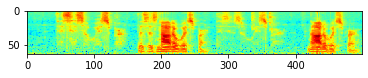

In [779]:
# lfbe = lfbe[::-1,:]
plt.imshow(lfbe, cmap='jet')


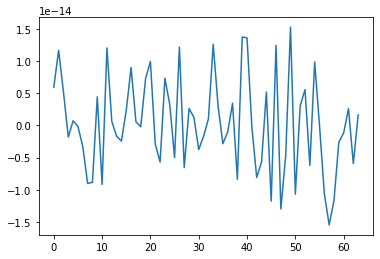

In [780]:
plt.plot(lfbe.mean(1))

In [781]:
feedme = np.pad(feedme, ((0,0),(0,1),(0,3)))

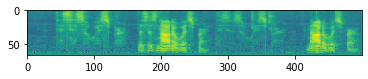

In [782]:
plt.imshow(feedme[0].T)

In [783]:
feed_dict = {input_spec: feedme}

In [784]:
h3_np = sess.run(h3, feed_dict)

In [785]:
h3_np.shape

(1, 500, 2)

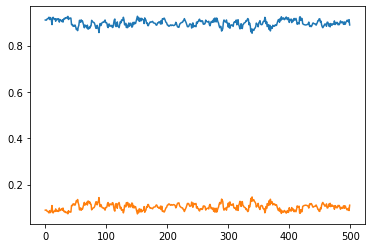

In [787]:
plt.plot(h3_np[0,:,0])
plt.plot(h3_np[0,:,1])

In [788]:
h3_np[0,200,1]

0.110736765

In [789]:
h3_np[0,200,1]

0.110736765